
## EDA & Pre-processing (Make sure to remove all non-numeric entries from numeric columns) 

In [9]:
import pandas as pd

car_df = pd.read_csv("cars-dataset.csv")
print(car_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
car name    398 non-null object
cyl         398 non-null int64
disp        398 non-null float64
hp          398 non-null object
wt          398 non-null int64
acc         398 non-null float64
yr          398 non-null int64
mpg         398 non-null float64
dtypes: float64(3), int64(3), object(2)
memory usage: 25.0+ KB
None


1. From above information from data set, we can find there are null values, but being object as type of the 'hp' column we can see there are some missing value '?' in this column. These values can be replaced with mean/median of the hp column.

In [10]:
import numpy as np

car_df = car_df.drop('car name', axis=1)
car_df = car_df.replace('?', np.nan)

In [11]:
car_df[car_df.isnull().any(axis=1)]

,cyl,disp,hp,wt,acc,yr,mpg
32,4,98.0,NaN,2046,19.0,71,25.0
126,6,200.0,NaN,2875,17.0,74,21.0
330,4,85.0,NaN,1835,17.3,80,40.9
336,4,140.0,NaN,2905,14.3,80,23.6
354,4,100.0,NaN,2320,15.8,81,34.5
374,4,151.0,NaN,3035,20.5,82,23.0


In [12]:
car_df.hp = pd.to_numeric(car_df.hp, errors='coerce')
car_df = car_df.apply(lambda x: x.fillna(x.median()),axis=0)

In [13]:
car_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cyl,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
disp,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
hp,398.0,104.304020,38.222625,46.0,76.000,93.5,125.000,230.0
wt,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acc,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
yr,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6


In [14]:
car_df_attr = car_df.iloc[:, 0:7]

## Use pair plot or scatter matrix to visualize how the different variables are related (Hint: The amount of Gaussian curves in the plot should give a visual identification of different clusters existing in the dataset) 

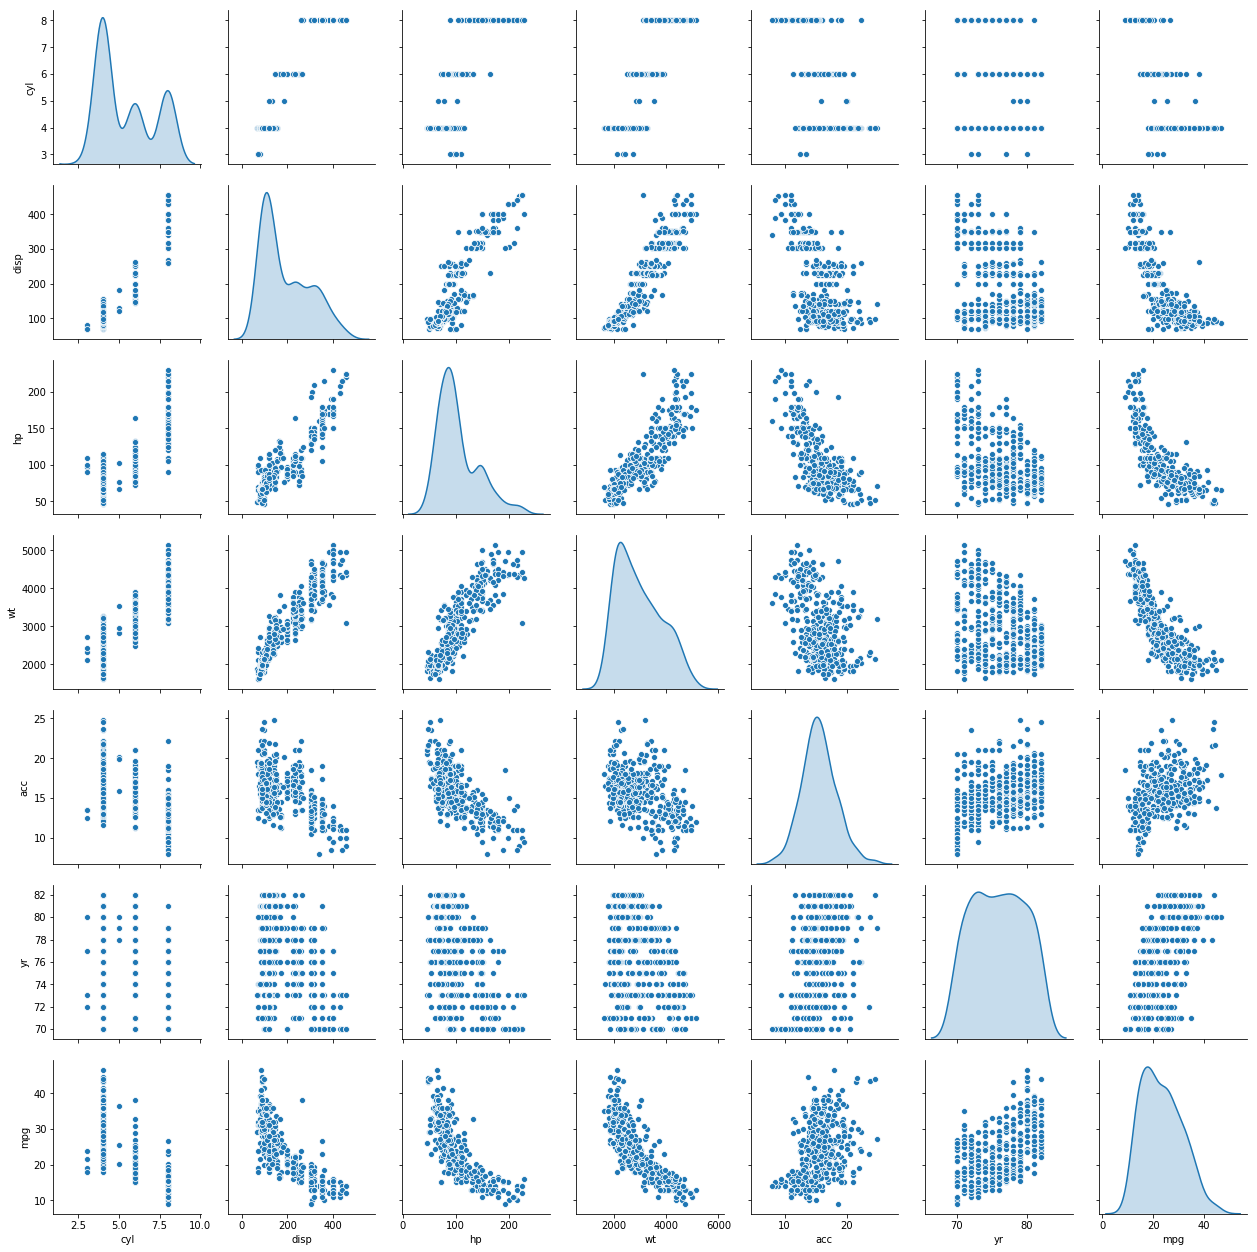

In [16]:
import seaborn as sns
sns.pairplot(car_df_attr, diag_kind='kde')

As there are 3 Gaussian curves in Cyl distribution and 2 Gaussian curves in Disp distribution, there could be 3 to 6 clusters in the given sample.

## Use K Means or Hierarchical clustering to find out the optimal no of clusters in the data. Identify and separate the clusters

In [17]:
from scipy.stats import zscore
car_df_attr_scaled_copy = car_df_attr_scaled = car_df_attr.apply(zscore)
#car_df_attr_scaled.pop('yr')
array = car_df_attr_scaled.values

In [18]:
from sklearn.cluster import KMeans
cluster_range = range( 2, 6)   
# expect 3 to four clusters from the pair panel visual inspection hence restricting from 2 to 6
cluster_errors = []
for num_clusters in cluster_range:
  clusters = KMeans( num_clusters, n_init = 5)
  clusters.fit(car_df_attr_scaled)
  labels = clusters.labels_
  centroids = clusters.cluster_centers_
  cluster_errors.append( clusters.inertia_ )
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_df[0:15]

,num_clusters,cluster_errors
0,2,1294.841895
1,3,946.019791
2,4,738.415974
3,5,664.889003


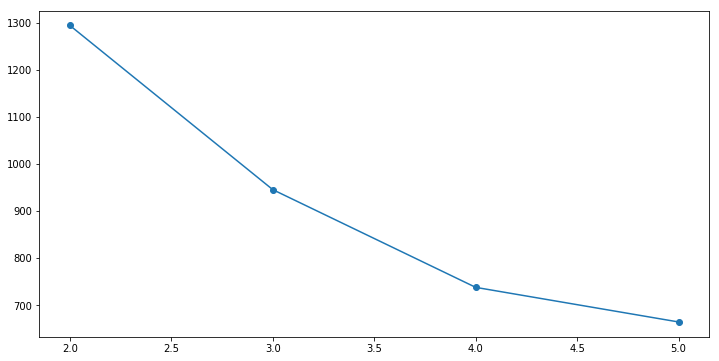

In [19]:
import matplotlib.pylab as plt
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [20]:
# There could be 3 or 4 clusters, since below boxplot does not overlap on 3 clusters for many attributes, 
# it is good to consider 3 clusters.

cluster = KMeans( n_clusters = 3, random_state = 98789 )
cluster.fit(car_df_attr_scaled)
car_df_attr_scaled_copy = car_df_attr_scaled.copy(deep = True) 

In [21]:
centroids = cluster.cluster_centers_
centroids

array([[ 1.49819126,  1.50068407,  1.51412926,  1.40001604, -1.07612225,
        -0.6725559 , -1.15871315],
       [-0.85347696, -0.80321374, -0.67506194, -0.78549879,  0.36133415,
         0.30992304,  0.75394661],
       [ 0.35772459,  0.24687769, -0.04275477,  0.30829922,  0.28578589,
        -0.00272145, -0.47905415]])

In [22]:
centroid_df = pd.DataFrame(centroids, columns = list(car_df_attr_scaled) )
centroid_df

,cyl,disp,hp,wt,acc,yr,mpg
0,1.498191,1.500684,1.514129,1.400016,-1.076122,-0.672556,-1.158713
1,-0.853477,-0.803214,-0.675062,-0.785499,0.361334,0.309923,0.753947
2,0.357725,0.246878,-0.042755,0.308299,0.285786,-0.002721,-0.479054


In [23]:
prediction=cluster.predict(car_df_attr_scaled)
car_df_attr_scaled["GROUP"] = prediction 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1a190240>,
      dtype=object)

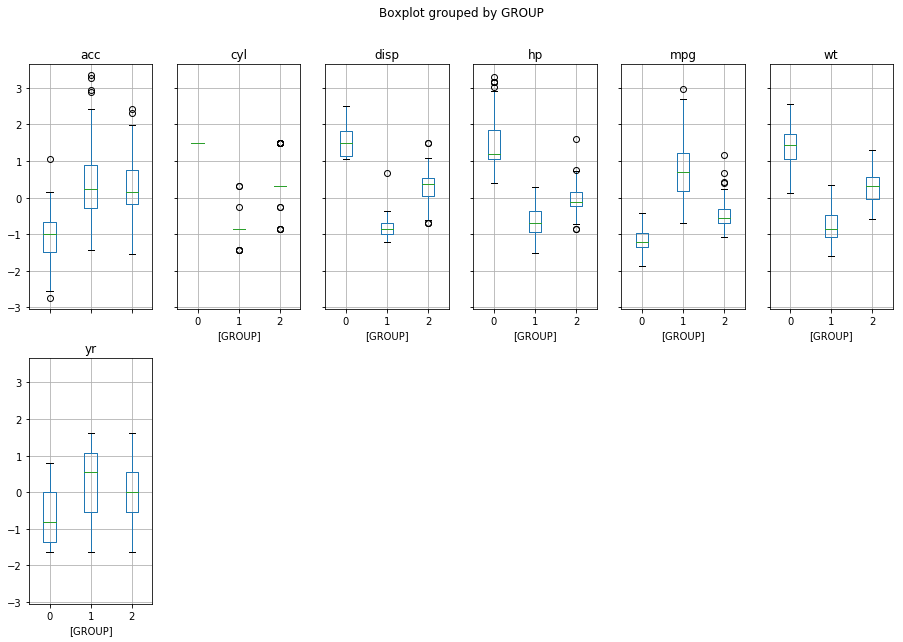

In [24]:
import matplotlib.pylab as plt
car_df_attr_scaled.boxplot(by = 'GROUP',  layout=(2,6), figsize=(15, 10))

In [25]:
# Addressing outliers at group level

data = car_df_attr_scaled   # lazy to type long names. Renaming it to data. Remember data is not a copy of the dataframe
       
def replace(group):
    median, std = group.median(), group.std()  #Get the median and the standard deviation of every group 
    outliers = (group - median).abs() > 2*std # Subtract median from every member of each group. Take absolute values > 2std
    group[outliers] = group.median() # replacing group outliers with group median      
    return group

data_corrected = (data.groupby('GROUP').transform(replace)) 
concat_data = data_corrected.join(pd.DataFrame(car_df_attr_scaled['GROUP']))

/Users/malarvizhi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1abe2fd0>,
      dtype=object)

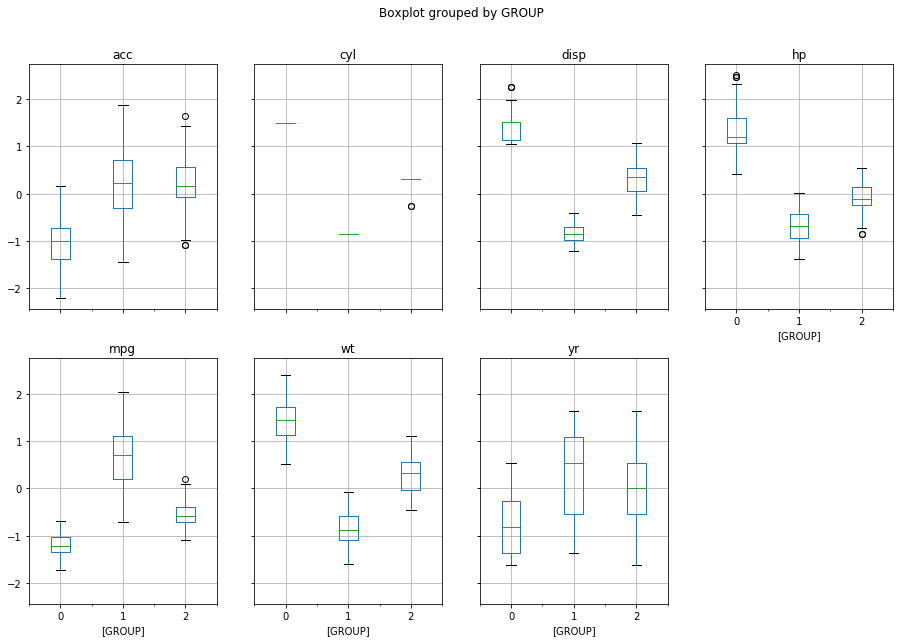

In [26]:
concat_data.boxplot(by = 'GROUP', layout=(2,4), figsize=(15, 10))

/Users/malarvizhi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


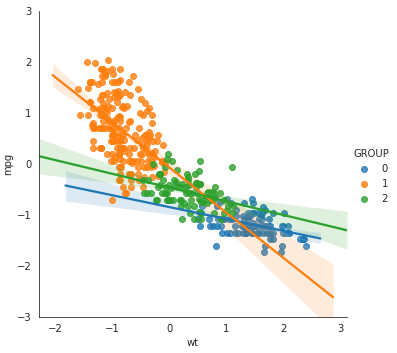

In [27]:
# mpg Vs wt

var = 'wt'

with sns.axes_style("white"):
    plot = sns.lmplot(var,'mpg',data=concat_data,hue='GROUP')
plot.set(ylim = (-3,3))

## Use linear regression model on different clusters separately and print the coefficients of the models individually 

In [28]:
grp1 = concat_data[car_df_attr_scaled.GROUP == 0]
grp2 = concat_data[car_df_attr_scaled.GROUP == 1]
grp3 = concat_data[car_df_attr_scaled.GROUP == 2]

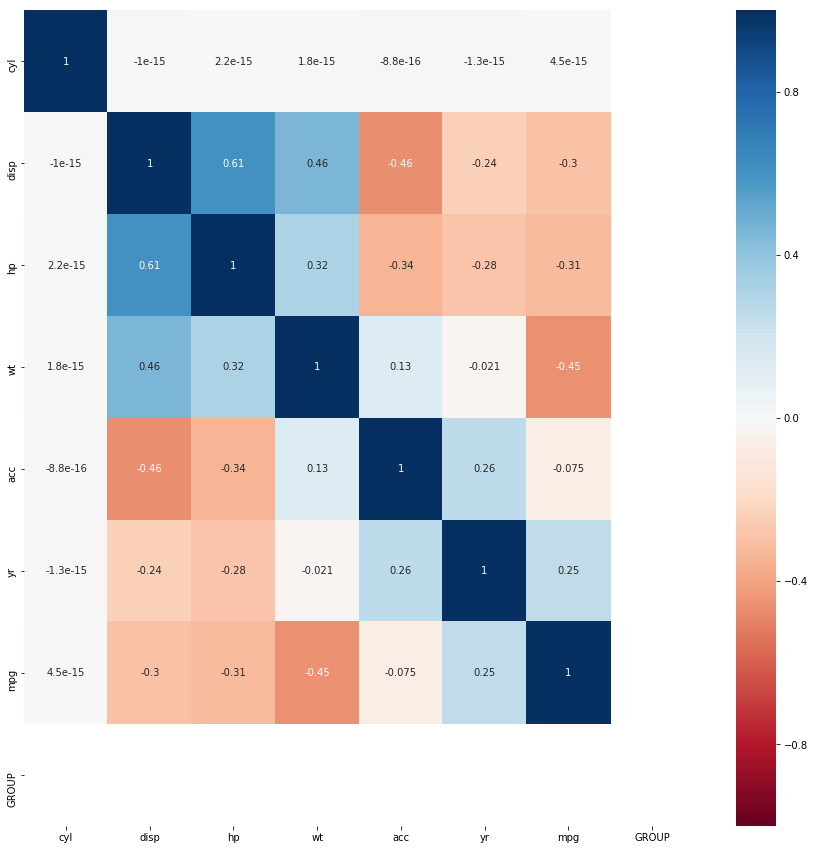

In [29]:
plt.figure(figsize=(15,15))
sns.heatmap(grp1.corr(), vmin=-1, vmax=1, annot=True, cmap='RdBu')

Mpg is negatively correlated to disp, hp, wt, Acc,cyl; and yr is weekly correlated to mpg.

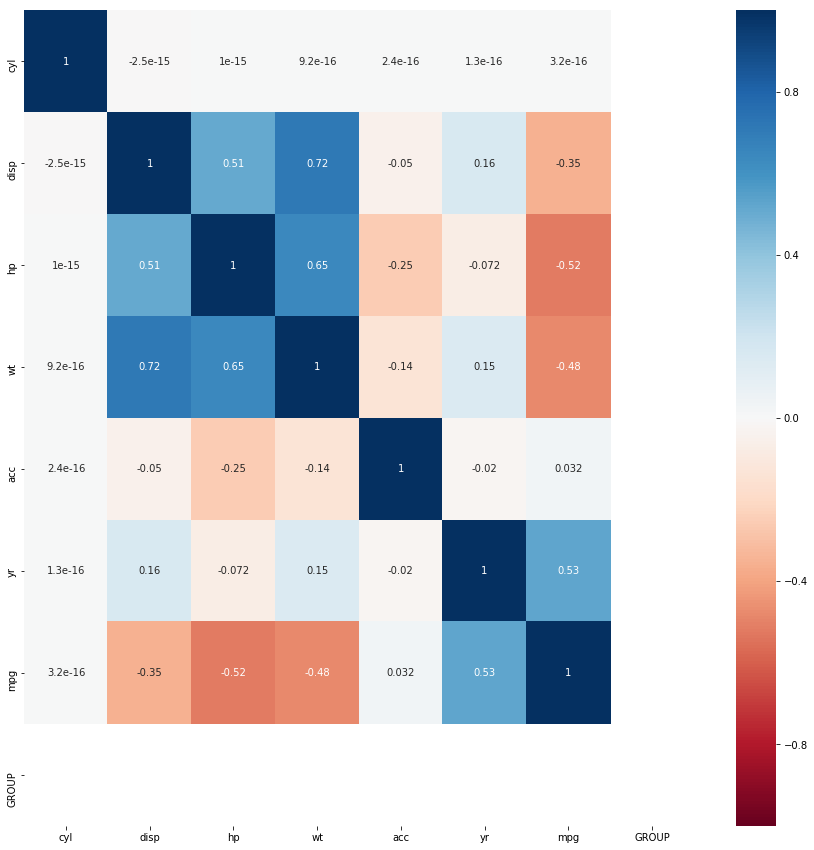

In [30]:
plt.figure(figsize=(15,15))
sns.heatmap(grp2.corr(), vmin=-1, vmax=1, annot=True, cmap='RdBu')

Except Acc & Yr, rest of the columns are negatively correlated to mpg in Group 2

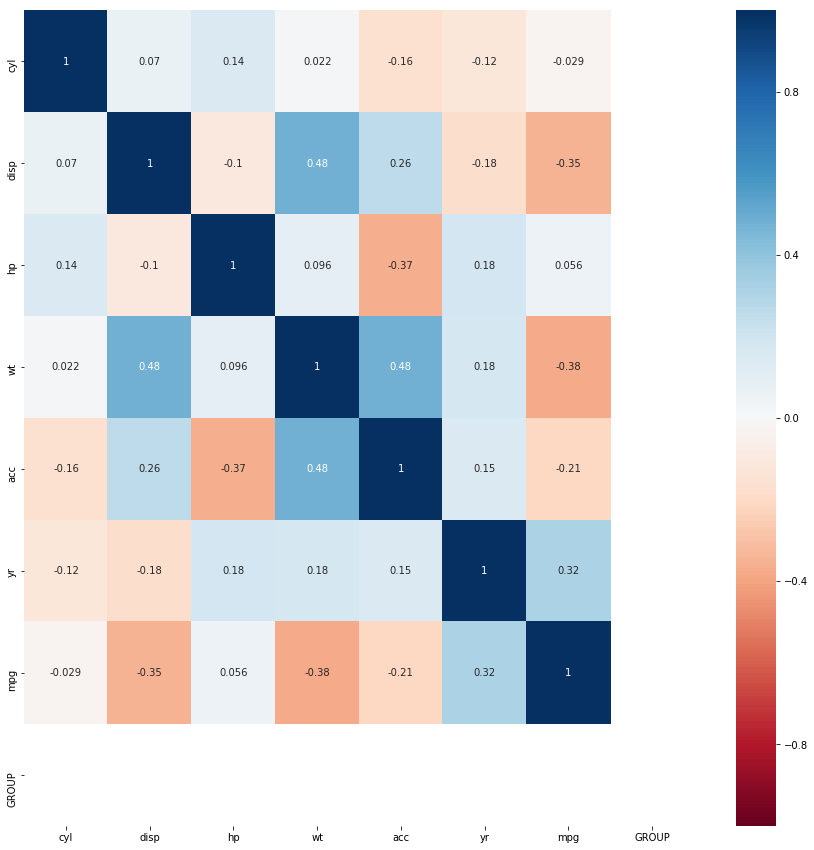

In [31]:
plt.figure(figsize=(15,15))
sns.heatmap(grp3.corr(), vmin=-1, vmax=1, annot=True, cmap='RdBu')

Except hp and yr, rest of the columns are negatively correlated to mpg column in the cluster3.

In [32]:
# Copy all the predictor variables into X dataframe for Group 1. Since 'mpg' is dependent variable drop it
grp1_X = grp1.drop('mpg', axis=1)

# Copy the 'mpg' column alone into the y dataframe. This is the dependent variable
grp1_y = grp1[['mpg']]

In [43]:
from sklearn.model_selection import train_test_split
grp1_X_train, grp1_X_test, grp1_y_train, grp1_y_test = train_test_split(grp1_X, grp1_y, test_size=0.30, 
                                                                        random_state=78)
from sklearn.linear_model import LinearRegression

grp1_regression_model = LinearRegression()
grp1_regression_model.fit(grp1_X_train, grp1_y_train)

grp1_score = grp1_regression_model.score(grp1_X_test, grp1_y_test)
print('The Gropu 1 score is {0}'.format(grp1_score))

The Gropu 1 score is 0.2901086097432448


In [45]:
# Copy all the predictor variables into X dataframe for Group 2. Since 'mpg' is dependent variable drop it
grp2_X = grp2.drop('mpg', axis=1)
grp2_y = grp2[['mpg']]
grp2_X_train, grp2_X_test, grp2_y_train, grp2_y_test = train_test_split(grp2_X, grp2_y, 
                                                                        test_size=0.30, random_state=98789)
grp2_regression_model = LinearRegression()
grp2_regression_model.fit(grp2_X_train, grp2_y_train)
grp2_score = grp2_regression_model.score(grp2_X_test, grp2_y_test)
print('The Gropu 2 score is {0}'.format(grp2_score))

The Gropu 2 score is 0.6893133457706548


In [46]:
# Copy all the predictor variables into X dataframe for Group 3. Since 'mpg' is dependent variable drop it
grp3_X = grp3.drop('mpg', axis=1)
grp3_y = grp3[['mpg']]
grp3_X_train, grp3_X_test, grp3_y_train, grp3_y_test = train_test_split(grp3_X, grp3_y, test_size=0.30, 
                                                                        random_state=33)
grp3_regression_model = LinearRegression()
grp3_regression_model.fit(grp3_X_train, grp3_y_train)
grp3_score = grp3_regression_model.score(grp3_X_test, grp3_y_test)
print('The Gropu 3 score is {0}'.format(grp3_score))

The Gropu 3 score is 0.4648390394658557


Scores for the these groups are found to be very less. I changed the random state in many ways, these are highest scores I could get.

In [47]:
# Let us explore the coefficients for each of the independent attributes

for idx, col_name in enumerate(grp1_X_train.columns):
    print("The Group 1 coefficient for {} is {}".format(col_name, grp1_regression_model.coef_[0][idx]))

The Group 1 coefficient for cyl is 0.35935276545849226
The Group 1 coefficient for disp is -0.18854302768793343
The Group 1 coefficient for hp is -0.016109931384753577
The Group 1 coefficient for wt is -0.1252247860761736
The Group 1 coefficient for acc is -0.08130202825130022
The Group 1 coefficient for yr is 0.07921205590834321
The Group 1 coefficient for GROUP is 0.0


In [48]:
# Let us explore the coefficients for each of the independent attributes

for idx, col_name in enumerate(grp2_X_train.columns):
    print("The Group 2 coefficient for {} is {}".format(col_name, grp2_regression_model.coef_[0][idx]))

The Group 2 coefficient for cyl is 0.0
The Group 2 coefficient for disp is 0.06675274344366232
The Group 2 coefficient for hp is -0.46076461986007883
The Group 2 coefficient for wt is -0.7313937145799155
The Group 2 coefficient for acc is -0.09096225332769474
The Group 2 coefficient for yr is 0.3536128257237162
The Group 2 coefficient for GROUP is 0.0


In [49]:
# Let us explore the coefficients for each of the independent attributes

for idx, col_name in enumerate(grp3_X_train.columns):
    print("The Group 3 coefficient for {} is {}".format(col_name, grp3_regression_model.coef_[0][idx]))

The Group 3 coefficient for cyl is 0.039182591647292084
The Group 3 coefficient for disp is -0.05488810835318557
The Group 3 coefficient for hp is -0.018447719940245418
The Group 3 coefficient for wt is -0.24133101038533666
The Group 3 coefficient for acc is -0.04851188028849816
The Group 3 coefficient for yr is 0.11576266033403204
The Group 3 coefficient for GROUP is 0.0


In [50]:
grp1_intercept = grp1_regression_model.intercept_[0]
grp2_intercept = grp2_regression_model.intercept_[0]
grp3_intercept = grp3_regression_model.intercept_[0]

print("The intercept for Group 1 model is {}".format(grp1_intercept))
print("The intercept for Group 2 model is {}".format(grp2_intercept))
print("The intercept for Group 3 model is {}".format(grp3_intercept))

The intercept for Group 1 model is -1.2689123933606798
The intercept for Group 2 model is -0.30528070071429736
The intercept for Group 3 model is -0.4787372127007848
